# DSP Final Exam: Traffic Accidents Time Series Analysis

**Objective:** Decompose, Denoise, and Interpret traffic accident data through FFT analysis, spectral filtering, and correlation assessment.

---

## Table of Contents
1. [Introduction](#introduction)
2. [Methodology](#methodology)
3. [Data Preprocessing](#data-preprocessing)
4. [FFT Analysis](#fft-analysis)
5. [Spectral Filtering](#spectral-filtering)
6. [Correlation Analysis](#correlation-analysis)
7. [Results and Discussion](#results-discussion)
8. [Conclusion](#conclusion)
9. [References](#references)

---

## 1. Introduction <a id='introduction'></a>

### Dataset Description
- **Source:** Kaggle - Traffic Accidents Dataset
- **Size:** 209,306 records × 24 columns
- **Time Period:** 2015-2023
- **Variables:** Crash date/time, weather conditions, lighting, injuries, traffic control devices

### Engineering Relevance
Traffic accident analysis is critical for:
- Urban planning and road safety improvements
- Emergency response resource allocation
- Identifying high-risk time periods
- Understanding environmental factors affecting accidents

### Project Goals
1. Create time series from accident counts (hourly, daily, weekly)
2. Apply FFT to identify periodic patterns in accident occurrence
3. Use spectral filtering to isolate daily/weekly cycles
4. Correlate accidents with weather, lighting, and time factors

---

## 2. Methodology <a id='methodology'></a>

### Tools and Libraries
| Library | Purpose |
|---------|----------|
| `pandas` | Data loading and manipulation |
| `numpy` | Numerical computations and FFT |
| `scipy` | Signal processing and filtering |
| `matplotlib` | Data visualization |
| `seaborn` | Statistical visualization |

---

## 3. Data Preprocessing <a id='data-preprocessing'></a>

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt, freqz
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported!")

✅ Libraries imported!


In [15]:
# Load dataset
df = pd.read_csv('../data/traffic_accidents.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (209306, 24)

Columns: ['crash_date', 'traffic_control_device', 'weather_condition', 'lighting_condition', 'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'crash_type', 'intersection_related_i', 'damage', 'prim_contributory_cause', 'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour', 'crash_day_of_week', 'crash_month']


,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,7/29/2023 13:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0,0,0,0,0,3,13,7,7
1,8/13/2023 0:11,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0,0,0,0,0,2,0,1,8
2,12/9/2021 10:30,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0,0,0,0,0,3,10,5,12
3,8/9/2023 19:55,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5,0,0,5,0,0,19,4,8
4,8/19/2023 14:55,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0,0,0,0,0,3,14,7,8


In [16]:
# Convert crash_date to datetime
df['crash_date'] = pd.to_datetime(df['crash_date'])
df['date'] = df['crash_date'].dt.date

# FILTER DATA: Include 2017 onwards
print(f"Original Dataset Shape: {df.shape}")
df = df[df['crash_date'] >= '2017-01-01']
print(f"Filtered Dataset Shape (2017-2025): {df.shape}")

# Check missing values
print("Missing Values:")
print(df.isnull().sum())

# Fill numeric missing values with 0
numeric_cols = ['injuries_total', 'injuries_fatal', 'injuries_incapacitating', 
                'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication']
df[numeric_cols] = df[numeric_cols].fillna(0)

print(f"\nDate range: {df['crash_date'].min()} to {df['crash_date'].max()}")

Original Dataset Shape: (209306, 25)
Filtered Dataset Shape (2017-2025): (199772, 25)
Missing Values:
crash_date                       0
traffic_control_device           0
weather_condition                0
lighting_condition               0
first_crash_type                 0
trafficway_type                  0
alignment                        0
roadway_surface_cond             0
road_defect                      0
crash_type                       0
intersection_related_i           0
damage                           0
prim_contributory_cause          0
num_units                        0
most_severe_injury               0
injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_no_indication           0
crash_hour                       0
crash_day_of_week                0
crash_month                      0
date                             0
dtype: int64

Date rang

In [17]:
# Create daily accident count time series
daily_accidents = df.groupby('date').size().reset_index(name='accident_count')
daily_accidents['date'] = pd.to_datetime(daily_accidents['date'])
daily_accidents = daily_accidents.set_index('date').asfreq('D', fill_value=0)

# Create hourly accident count
hourly_counts = df.groupby('crash_hour').size()

# Create day of week counts
dow_counts = df.groupby('crash_day_of_week').size()

print(f"Daily time series length: {len(daily_accidents)}")
print(f"\nDaily accidents statistics:")
print(daily_accidents['accident_count'].describe())

Daily time series length: 2940

Daily accidents statistics:
count    2940.000000
mean       67.949660
std        18.486604
min         1.000000
25%        57.000000
50%        69.000000
75%        79.000000
max       155.000000
Name: accident_count, dtype: float64


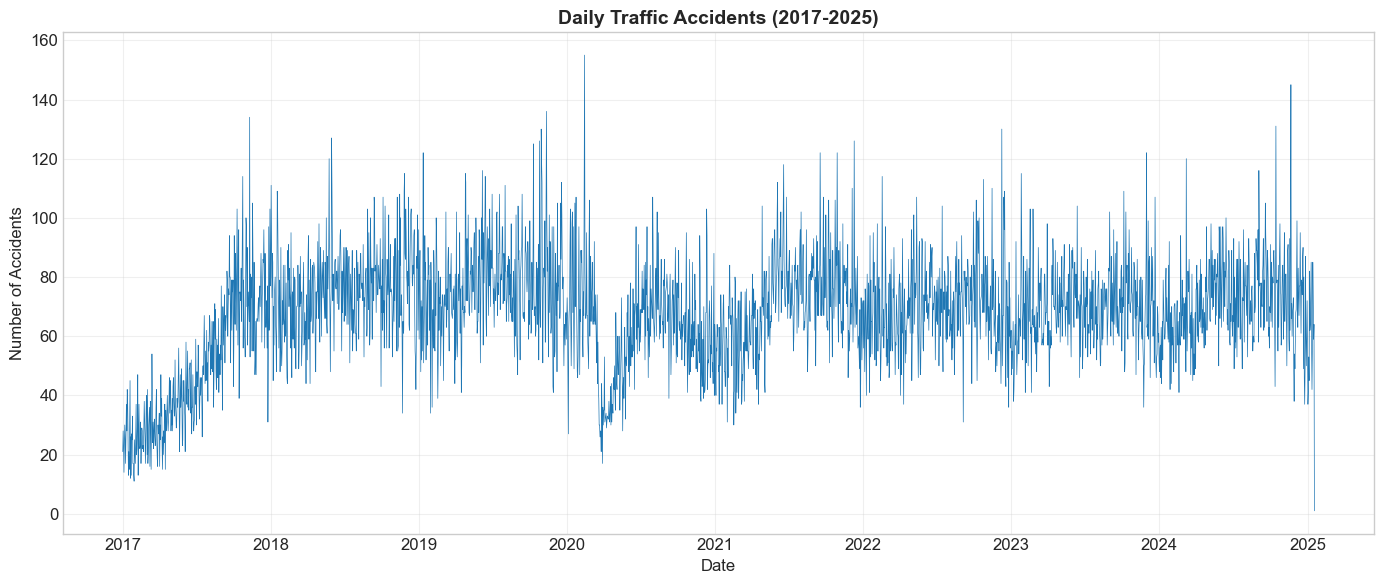

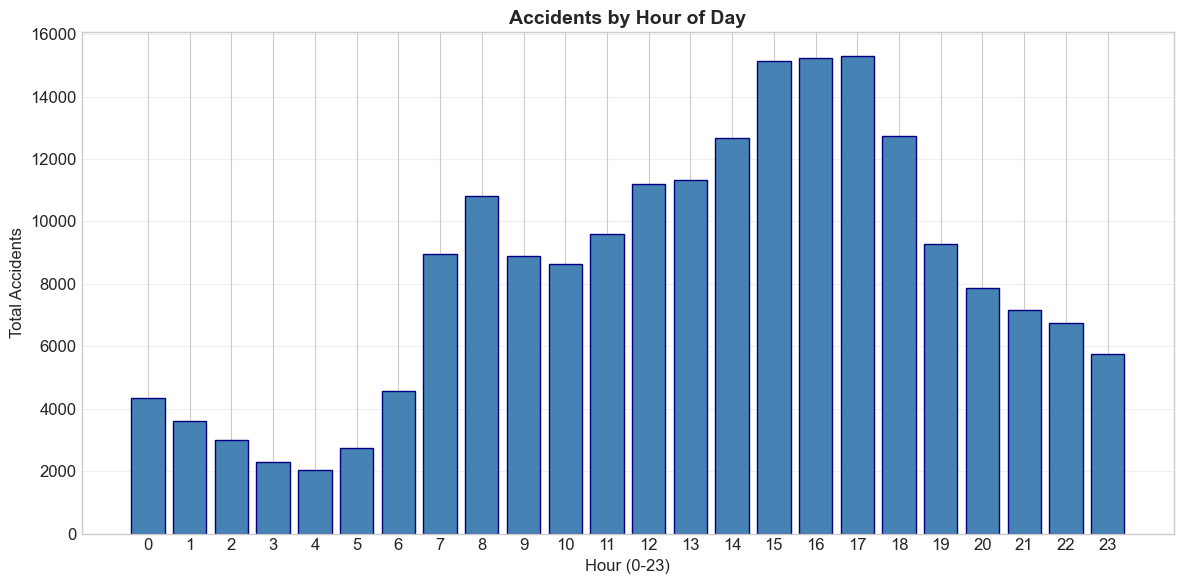

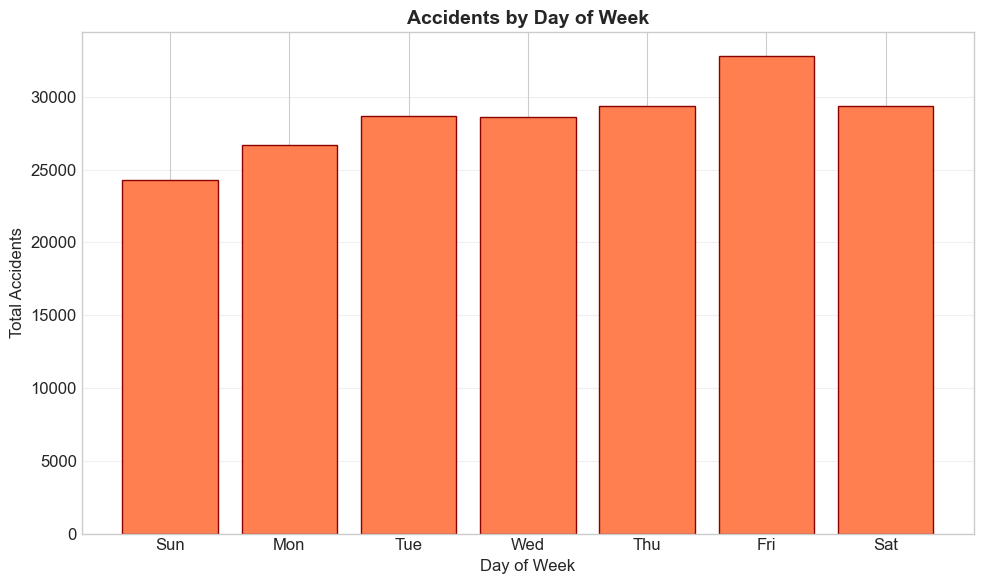

In [18]:
# Plot 1: Daily Accidents Time Series
plt.figure(figsize=(14, 6))
plt.plot(daily_accidents.index, daily_accidents['accident_count'], linewidth=0.5)
plt.title('Daily Traffic Accidents (2017-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/daily_accidents_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Hourly Distribution
plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='steelblue', edgecolor='navy')
plt.title('Accidents by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour (0-23)')
plt.ylabel('Total Accidents')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/hourly_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Day of Week Distribution
dow_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), [dow_counts.get(i, 0) for i in range(1, 8)], color='coral', edgecolor='darkred')
plt.title('Accidents by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Total Accidents')
plt.xticks(range(1, 8), dow_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/day_of_week_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 4. FFT Analysis <a id='fft-analysis'></a>

In [19]:
def compute_fft(signal_data, sampling_rate=1):
    """Compute FFT and return frequency and magnitude."""
    n = len(signal_data)
    fft_result = fft(signal_data)
    freqs = fftfreq(n, 1/sampling_rate)
    
    positive_idx = freqs >= 0
    freqs_pos = freqs[positive_idx]
    magnitude = np.abs(fft_result[positive_idx]) * 2 / n
    
    return freqs_pos, magnitude, fft_result

def plot_spectrum(freqs, magnitude, title, top_n=5):
    """Plot frequency spectrum with peak annotations."""
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(freqs[1:], magnitude[1:], 'b-', linewidth=0.8)  # Skip DC
    ax.fill_between(freqs[1:], magnitude[1:], alpha=0.3)
    
    # Find and annotate peaks
    peak_idx = np.argsort(magnitude[1:])[-top_n:][::-1] + 1
    for idx in peak_idx:
        if magnitude[idx] > np.mean(magnitude) * 2:
            period = 1/freqs[idx] if freqs[idx] > 0 else 0
            ax.annotate(f'{period:.1f} days',
                       xy=(freqs[idx], magnitude[idx]),
                       xytext=(freqs[idx], magnitude[idx] * 1.15),
                       ha='center', fontsize=10,
                       arrowprops=dict(arrowstyle='->', color='red'))
            ax.plot(freqs[idx], magnitude[idx], 'ro', markersize=8)
    
    ax.set_title(f'Frequency Spectrum - {title}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Frequency (cycles/day)', fontsize=12)
    ax.set_ylabel('Magnitude', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 0.2)  # Focus on low frequencies
    
    plt.tight_layout()
    return fig

print("✅ FFT functions defined!")

✅ FFT functions defined!


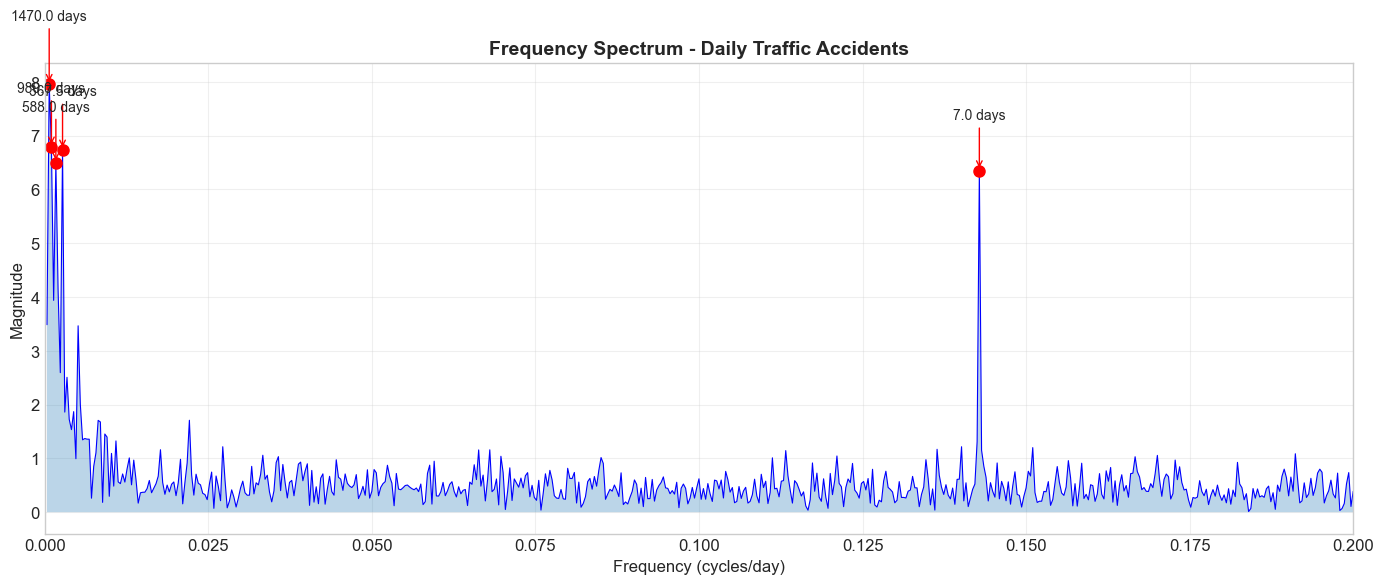


=== Dominant Frequencies ===
Frequency: 0.000680 cycles/day | Period: 1470.00 days | Magnitude: 7.95
Frequency: 0.001020 cycles/day | Period: 980.00 days | Magnitude: 6.79
Frequency: 0.002721 cycles/day | Period: 367.50 days | Magnitude: 6.73
Frequency: 0.001701 cycles/day | Period: 588.00 days | Magnitude: 6.49
Frequency: 0.142857 cycles/day | Period: 7.00 days | Magnitude: 6.35
Frequency: 0.285714 cycles/day | Period: 3.50 days | Magnitude: 5.02
Frequency: 0.002041 cycles/day | Period: 490.00 days | Magnitude: 4.13
Frequency: 0.001361 cycles/day | Period: 735.00 days | Magnitude: 3.94
Frequency: 0.000340 cycles/day | Period: 2940.00 days | Magnitude: 3.49
Frequency: 0.005102 cycles/day | Period: 196.00 days | Magnitude: 3.47


In [20]:
# Apply FFT to daily accident counts
signal = daily_accidents['accident_count'].values
sampling_rate = 1  # 1 sample per day

freqs, magnitude, fft_result = compute_fft(signal, sampling_rate)

# Plot spectrum
fig = plot_spectrum(freqs, magnitude, 'Daily Traffic Accidents')
plt.savefig('../outputs/fft_spectrum_daily.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify dominant frequencies
print("\n=== Dominant Frequencies ===")
top_peaks = np.argsort(magnitude[1:])[-10:][::-1] + 1
for idx in top_peaks:
    if freqs[idx] > 0:
        period = 1/freqs[idx]
        print(f"Frequency: {freqs[idx]:.6f} cycles/day | Period: {period:.2f} days | Magnitude: {magnitude[idx]:.2f}")

---

## 5. Spectral Filtering <a id='spectral-filtering'></a>

In [21]:
def butterworth_filter(data, cutoff, fs, order=4, btype='low'):
    """Apply Butterworth filter."""
    nyq = 0.5 * fs
    if isinstance(cutoff, tuple):
        normalized = (cutoff[0]/nyq, cutoff[1]/nyq)
    else:
        normalized = cutoff / nyq
    b, a = butter(order, normalized, btype=btype)
    return filtfilt(b, a, data), b, a

def frequency_filter(signal_data, fs, filter_type, cutoff):
    """Filter in frequency domain using IFFT."""
    n = len(signal_data)
    fft_result = fft(signal_data)
    freqs = fftfreq(n, 1/fs)
    
    if filter_type == 'lowpass':
        mask = np.abs(freqs) <= cutoff
    elif filter_type == 'highpass':
        mask = np.abs(freqs) >= cutoff
    elif filter_type == 'bandpass':
        mask = (np.abs(freqs) >= cutoff[0]) & (np.abs(freqs) <= cutoff[1])
    
    fft_filtered = fft_result * mask
    return np.real(ifft(fft_filtered)), fft_filtered

print("✅ Filter functions defined!")

✅ Filter functions defined!


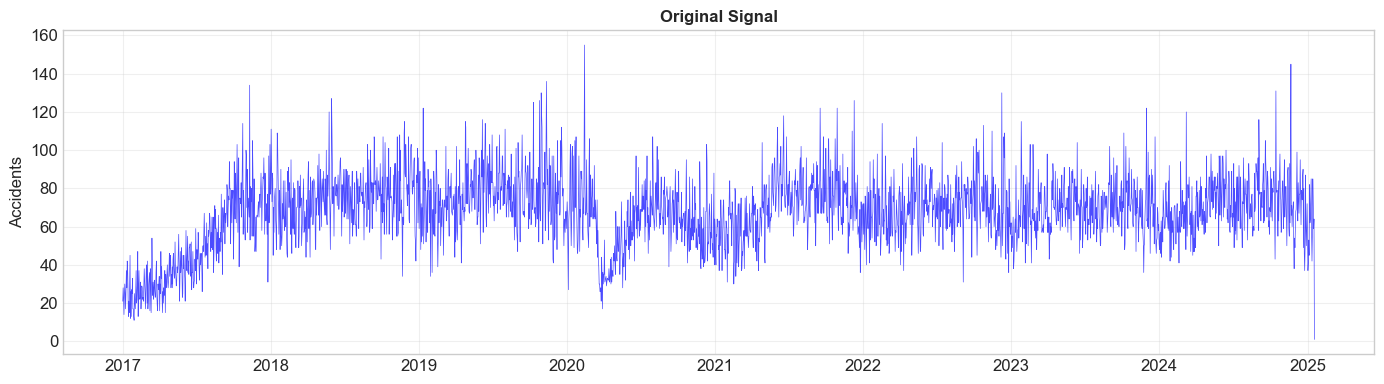

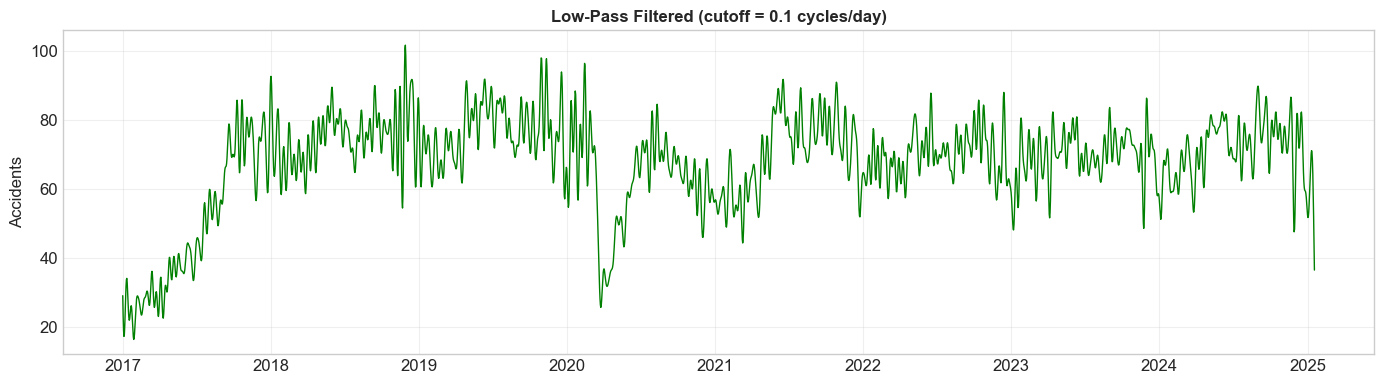

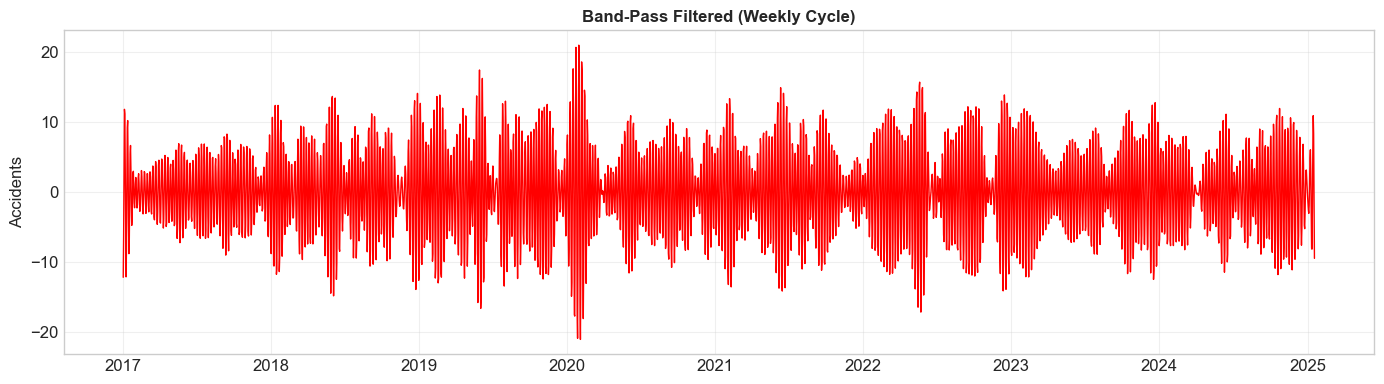

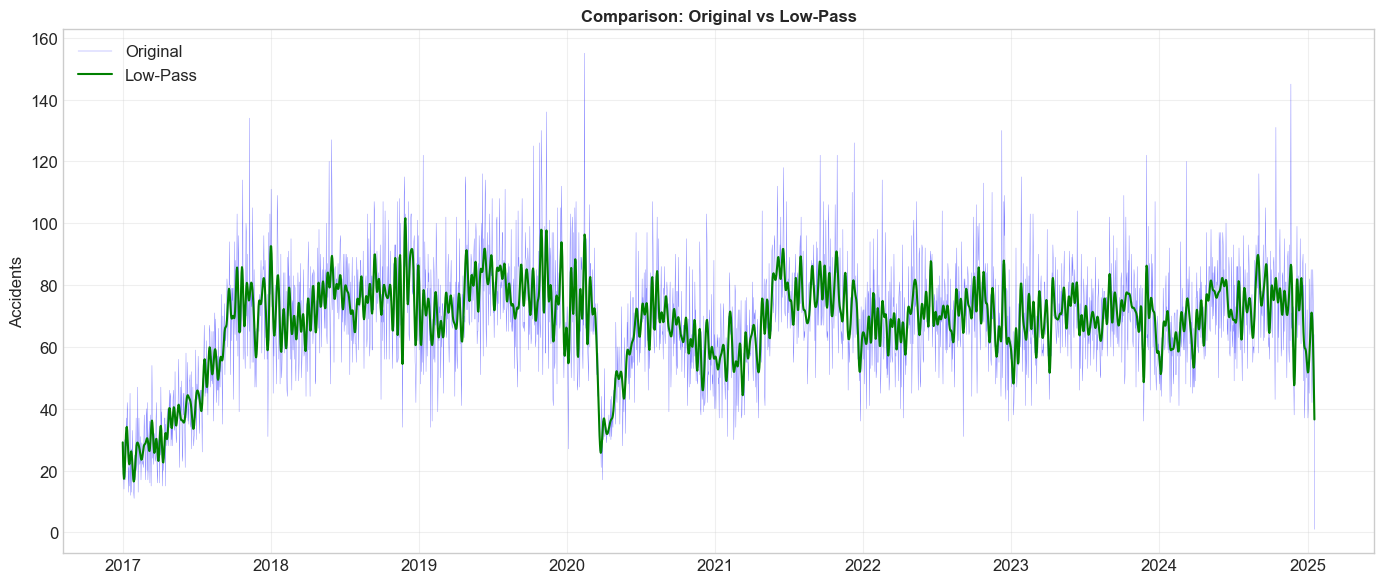

In [22]:
# Apply Low-Pass Filter (remove high-frequency noise)
cutoff_low = 0.1  # cycles/day
filtered_lowpass, fft_lp = frequency_filter(signal, 1, 'lowpass', cutoff_low)

# Apply Band-Pass Filter (isolate weekly cycle ~7 days = 0.143 cycles/day)
filtered_bandpass, fft_bp = frequency_filter(signal, 1, 'bandpass', (0.12, 0.16))

time = daily_accidents.index

# Plot 4: Original Signal
plt.figure(figsize=(14, 4))
plt.plot(time, signal, 'b-', linewidth=0.5, alpha=0.7)
plt.title('Original Signal', fontsize=12, fontweight='bold')
plt.ylabel('Accidents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/signal_original.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Low-Pass Filtered
plt.figure(figsize=(14, 4))
plt.plot(time, filtered_lowpass, 'g-', linewidth=1)
plt.title(f'Low-Pass Filtered (cutoff = {cutoff_low} cycles/day)', fontsize=12, fontweight='bold')
plt.ylabel('Accidents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/signal_lowpass.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 6: Band-Pass Filtered
plt.figure(figsize=(14, 4))
plt.plot(time, filtered_bandpass, 'r-', linewidth=1)
plt.title('Band-Pass Filtered (Weekly Cycle)', fontsize=12, fontweight='bold')
plt.ylabel('Accidents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/signal_bandpass.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 7: Comparisons
plt.figure(figsize=(14, 6))
plt.plot(time, signal, 'b-', linewidth=0.3, alpha=0.5, label='Original')
plt.plot(time, filtered_lowpass, 'g-', linewidth=1.5, label='Low-Pass')
plt.title('Comparison: Original vs Low-Pass', fontsize=12, fontweight='bold')
plt.ylabel('Accidents')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/signal_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. Correlation Analysis <a id='correlation-analysis'></a>

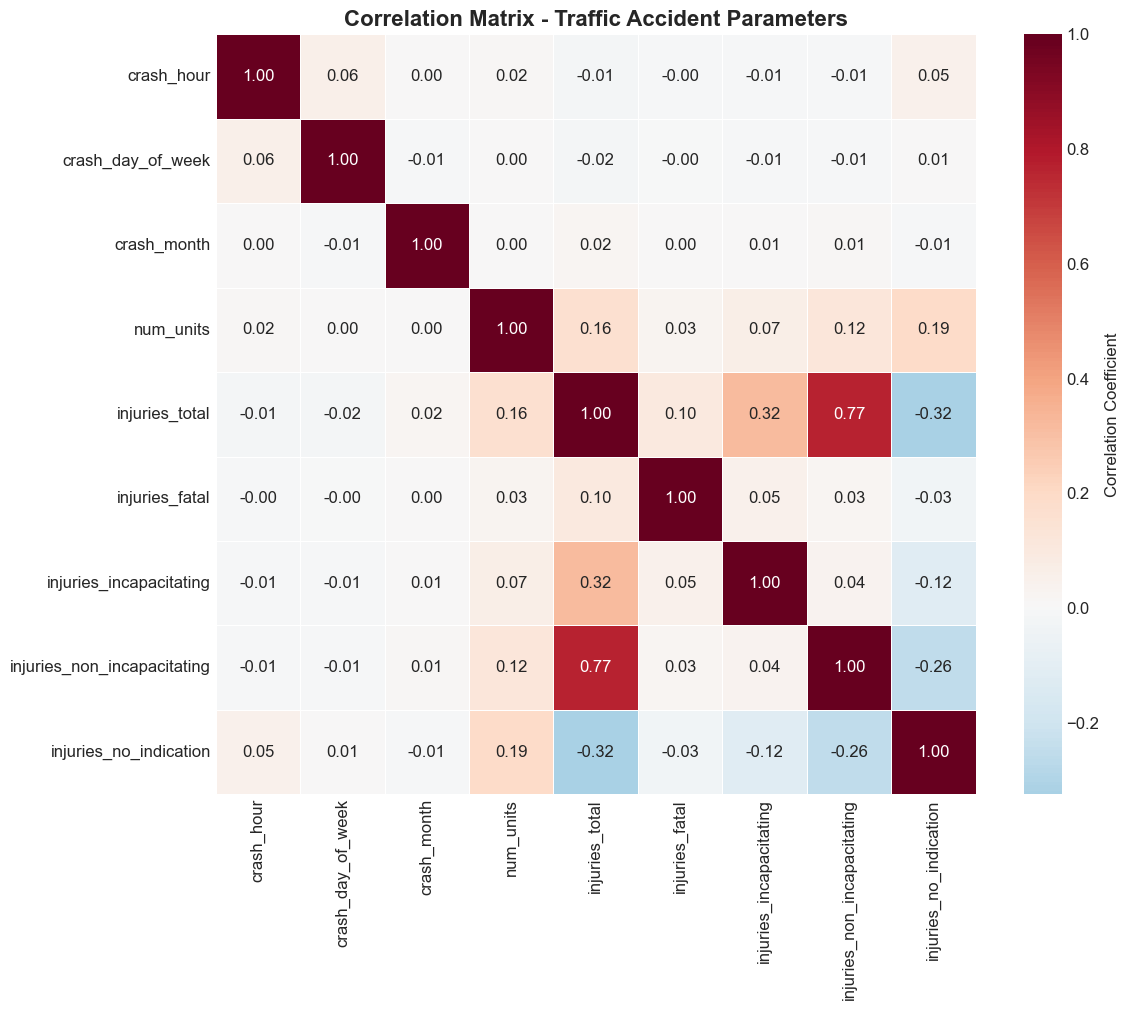

In [23]:
# Prepare numeric data for correlation
corr_df = df[['crash_hour', 'crash_day_of_week', 'crash_month', 'num_units',
              'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
              'injuries_non_incapacitating', 'injuries_no_indication']].copy()

correlation_matrix = corr_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu_r',
            center=0, linewidths=0.5, square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix - Traffic Accident Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

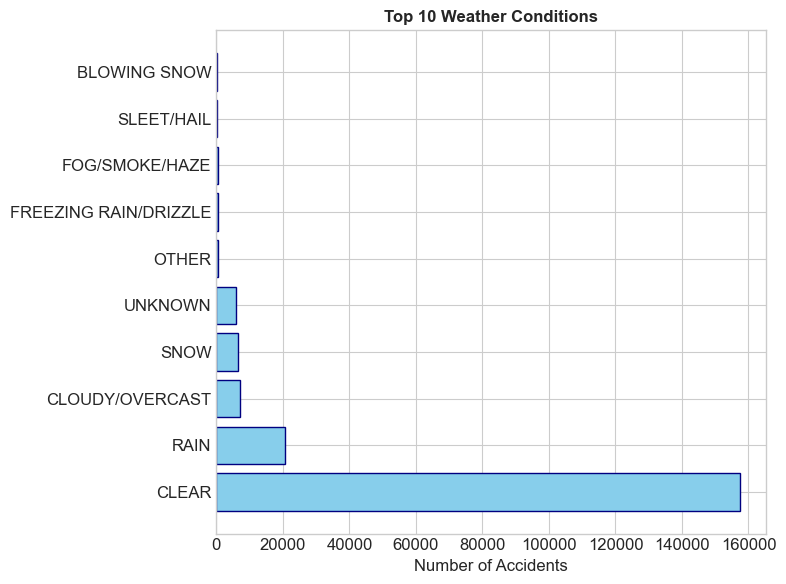

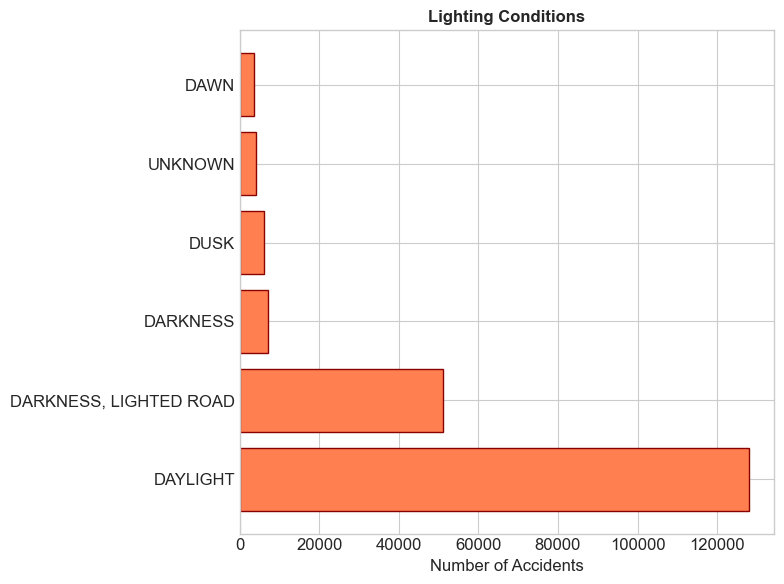

In [24]:
# Weather and lighting analysis
weather_counts = df['weather_condition'].value_counts()
lighting_counts = df['lighting_condition'].value_counts()

# Plot 8: Weather Conditions
plt.figure(figsize=(8, 6))
plt.barh(weather_counts.index[:10], weather_counts.values[:10], color='skyblue', edgecolor='navy')
plt.title('Top 10 Weather Conditions', fontsize=12, fontweight='bold')
plt.xlabel('Number of Accidents')
plt.tight_layout()
plt.savefig('../outputs/weather_conditions.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 9: Lighting Conditions
plt.figure(figsize=(8, 6))
plt.barh(lighting_counts.index[:8], lighting_counts.values[:8], color='coral', edgecolor='darkred')
plt.title('Lighting Conditions', fontsize=12, fontweight='bold')
plt.xlabel('Number of Accidents')
plt.tight_layout()
plt.savefig('../outputs/lighting_conditions.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Results and Discussion <a id='results-discussion'></a>

### FFT Analysis Results
[TODO: Discuss dominant frequencies - weekly cycle (~7 days), monthly patterns]

### Filtering Results  
[TODO: Discuss how low-pass filtering removes noise and reveals trends]

### Correlation Findings
[TODO: Discuss relationships between injuries, time of day, weather]

---

## 8. Conclusion <a id='conclusion'></a>

[TODO: Summarize key findings and real-world applications]

---

## 9. References <a id='references'></a>

1. Kaggle Traffic Accidents Dataset
2. NumPy FFT Documentation
3. SciPy Signal Processing

In [25]:
# Save cleaned data
daily_accidents.to_csv('../data/cleaned_daily_accidents.csv')
print("✅ Cleaned data saved!")

✅ Cleaned data saved!
